# Arctic Penguin Exploration: Unraveling Clusters in the Icy Domain with K-means clustering

You have been asked to support a team of researchers who have been collecting data about penguins in Antartica! 

**Origin of this data** : Data were collected and made available by Dr. Kristen Gorman and the Palmer Station, Antarctica LTER, a member of the Long Term Ecological Research Network.

**The dataset consists of 5 columns.**

- culmen_length_mm: culmen length (mm)
- culmen_depth_mm: culmen depth (mm)
- flipper_length_mm: flipper length (mm)
- body_mass_g: body mass (g)
- sex: penguin sex

Unfortunately, they have not been able to record the species of penguin, but they know that there are three species that are native to the region: **Adelie**, **Chinstrap**, and **Gentoo**, so your task is to apply your data science skills to help them identify groups in the dataset!

# Project Instructions: Utilize your unsupervised learning skills to reduce dimensionality and identify clusters in the penguins dataset!

1. Begin by reading in "data/penguins.csv" as a pandas DataFrame called penguins_df, then investigate and clean the dataset by removing the null values and outliers. Save as a cleaned DataFrame called penguins_clean.
2. Pre-process the cleaned data using standard scaling and the one-hot encoding to add dummy variables:
    1. Create the dummy variables and remove the original categorical feature from the dataset.
    1. Scale the data using the standard scaling method.
    1. Save the updated data as a new DataFrame called penguins_preprocessed.
1. Perform Principal Component Analysis (PCA) on the penguins_preprocessed dataset to determine the desired number of components, considering any component with an explained variance ratio above 10% as a suitable component. Save the number of components as a variable called n_components.
    1. Finally, execute PCA using n_components and store the result as penguins_PCA.
1. Employ k-means clustering on the penguins_PCA dataset, setting random_state=42, to determine the number of clusters through elbow analysis. Save the optimal number of clusters in a variable called n_cluster.
1. Create and fit a new k-means cluster model, setting n_cluster equal to your n_cluster variable, saving the model as a variable called kmeans.
    1. Visualize your clusters using the first two principle components.
6. Add the label column extracted from the k-means clustering (using kmeans.labels_) to the penguins_clean DataFrame.
7. Create a statistical table by grouping penguins_clean based on the "label" column and calculating the mean of each numeric column. Save this table as stat_penguins.

In [1]:
# Import Required Packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

## 1. Begin by reading in "data/penguins.csv" as a pandas DataFrame called penguins_df, then investigate and clean the dataset by removing the null values and outliers. Save as a cleaned DataFrame called penguins_clean.


In [2]:
# Loading the dataset
penguins_df = pd.read_csv("penguins.csv")

In [3]:
# Investigate the dataset 
# Identify shape of the dataset
penguins_df.shape

(344, 5)

In [4]:
# See the first 5 rows of the dataset
penguins_df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,NaN,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0,FEMALE


In [5]:
# More information about the dataset
penguins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB


In [6]:
# Count the number of missing values for each feature
penguins_df.isna().sum()

culmen_length_mm     2
culmen_depth_mm      2
flipper_length_mm    2
body_mass_g          2
sex                  9
dtype: int64

In [7]:
# Remove the null values
penguins_df_nonull = penguins_df.dropna(how='any')

In [8]:
# Count the values for sex for any abberant entries
penguins_df_nonull['sex'].value_counts()

MALE      169
FEMALE    165
.           1
Name: sex, dtype: int64

In [9]:
# Remove '.' from the sex column
mask = penguins_df_nonull['sex'] == '.'
penguins_df_nonull_noabberant = penguins_df_nonull[~mask]

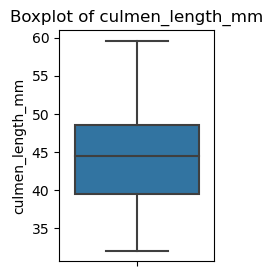

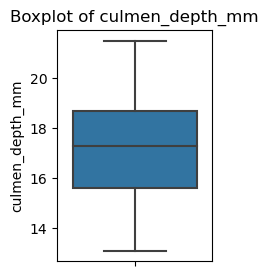

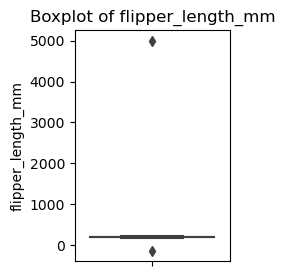

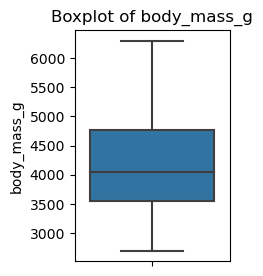

In [10]:
# Check for outliers
for col in penguins_df_nonull_noabberant.drop(['sex'], axis=1).columns:
    plt.figure(figsize=(2, 3))
    sns.boxplot(y=penguins_df_nonull_noabberant[col]).set_title(f'Boxplot of {col}')

Based on the above plots, it looks like flipper_length_mm has outliers

In [11]:
# Look at the numerical values to confirm the observation based on the boxplots above
penguins_df_nonull_noabberant.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,334.000000,334.000000,334.000000,334.000000
mean,43.986826,17.173952,214.347305,4207.185629
std,5.461540,1.973277,263.648447,804.009294
min,32.100000,13.100000,-132.000000,2700.000000
25%,39.500000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.575000,18.700000,213.000000,4768.750000
max,59.600000,21.500000,5000.000000,6300.000000


Flipper length has negative values, which is impossible. Also, the maximum value for that column is abnormally large, many standard deviations away. So, safe to drop these values from the column.

In [12]:
# Calculate the outliers mathematically

# Calculate the first and the third quartile
flipper_length_q1 = penguins_df_nonull_noabberant['flipper_length_mm'].quantile(0.25) 
flipper_length_q3 = penguins_df_nonull_noabberant['flipper_length_mm'].quantile(0.75)

# Calculate inter-quartile region
flipper_length_iqr = flipper_length_q3-flipper_length_q1

# Find the upper and lower extremes
upper_extreme = flipper_length_q3 + (flipper_length_iqr*1.5)
lower_extreme = flipper_length_q1 - (flipper_length_iqr*1.5)

In [13]:
# Identify outliers--any point below lower extreme
penguins_df_nonull_noabberant[penguins_df_nonull_noabberant['flipper_length_mm']<lower_extreme]

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
14,34.6,21.1,-132.0,4400.0,MALE


In [14]:
# Identify outliers--any point above upper extreme
penguins_df_nonull_noabberant[penguins_df_nonull_noabberant['flipper_length_mm']>upper_extreme]

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
9,42.0,20.2,5000.0,4250.0,MALE


In [15]:
# Remove the outliers from the flipper_length_mm
penguins_clean = penguins_df_nonull_noabberant[
    ~(penguins_df_nonull_noabberant['flipper_length_mm']<lower_extreme) & 
    ~(penguins_df_nonull_noabberant['flipper_length_mm']>upper_extreme)]

# 2. Pre-process the cleaned data using standard scaling and the one-hot encoding to add dummy variables:
   1. Create the dummy variables and remove the original categorical feature from the dataset.
   1. Scale the data using the standard scaling method.
   1. Save the updated data as a new DataFrame called penguins_preprocessed.

In [16]:
# Create the dummy variables and remove the original categorical feature from the dataset.
penguin_sex_dummy = pd.get_dummies(penguins_clean['sex'])

# Concatenate dummy variable in the original dataset
penguins_clean_dummy = pd.concat([penguins_clean, penguin_sex_dummy], axis=1)

# Remove the sex variable from the dataframe
penguins_clean_dummy_only = penguins_clean_dummy.drop(['sex'], axis=1)

In [17]:
# Scale the data using the standard scaling method

# Instantiate the StandardScaler
scaler = StandardScaler()

# Fit and transform the dataframe
transformed_df = scaler.fit_transform(penguins_clean_dummy_only)

# # Convert the scaled array to a pandas dataframe
penguins_preprocessed = pd.DataFrame((transformed_df), columns=penguins_clean_dummy_only.columns)

## 3. Perform Principal Component Analysis (PCA) on the penguins_preprocessed dataset to determine the desired number of components, considering any component with an explained variance ratio above 10% as a suitable component. 
   1. Save the number of components as a variable called n_components.
   1. Finally, execute PCA using n_components and store the result as penguins_PCA.

In [18]:
pca = PCA()
pca.fit(penguins_preprocessed)

PCA()

In [19]:
# Identify the explained variance ratio for each component
[round(i*100, 5) for i in pca.explained_variance_ratio_]

[52.03406, 34.46311, 8.58557, 3.22912, 1.68814, 0.0]

In [20]:
# Save the number of components as a variable called n_components
n_components = sum(pca.explained_variance_ratio_>0.1)

In [21]:
# Finally, execute PCA using n_components and store the result as penguins_PCA
pca = PCA(n_components=n_components)
penguins_PCA = pca.fit_transform(penguins_preprocessed)

# 4. Employ k-means clustering on the penguins_PCA dataset, setting random_state=42, to determine the number of clusters through elbow analysis. 
   1. Save the optimal number of clusters in a variable called n_cluster.

In [22]:
# Employ k-means clustering on the penguins_PCA dataset, setting random_state=42, to determine the number of clusters
inertia_dict = {}
for cluster in range(1,11):
    kmeans = KMeans(n_clusters=cluster, random_state=42, n_init='auto').fit(penguins_PCA)
    inertia_dict[cluster] = kmeans.inertia_

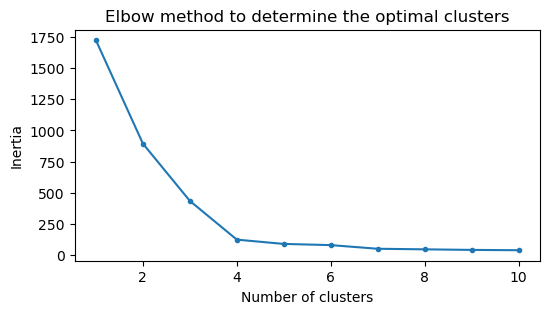

In [23]:
# Conduct elbow analysis
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(inertia_dict.keys(), inertia_dict.values(), marker='.')
ax.set_title('Elbow method to determine the optimal clusters')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Inertia')
plt.show()

In [24]:
# Save the optimal number of clusters in a variable called n_cluster
n_cluster = 4

# 5. Create and fit a new k-means cluster model, setting n_cluster equal to your n_cluster variable, saving the model as a variable called kmeans.
   1. Visualize your clusters using the first two principle components.

In [25]:
#Create and fit a new k-means cluster model, setting n_cluster equal to your n_cluster variable, saving the model as a variable called kmeans.
kmeans = KMeans(n_clusters=n_cluster, n_init='auto', random_state=42).fit(penguins_PCA)

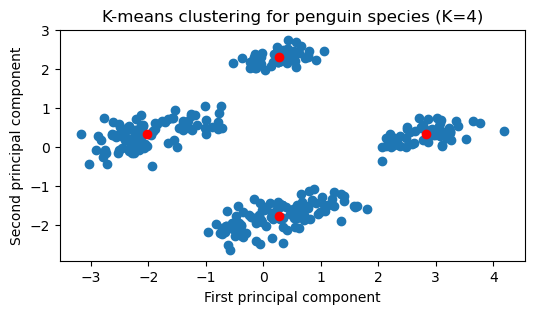

In [26]:
# Visualize the clusters using the first two principle components. 
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(penguins_PCA[:, 0], penguins_PCA[:, 1])
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:, 1], c='red')
ax.set_title(f'K-means clustering for penguin species (K={n_cluster})')
ax.set_xlabel('First principal component')
ax.set_ylabel('Second principal component')
plt.show()

# 6. Add the label column extracted from the k-means clustering (using kmeans.labels_) to the penguins_clean DataFrame.

In [27]:
# Add the label column extracted from the k-means clustering (using kmeans.labels_) to the penguins_clean DataFrame.
penguins_clean = pd.concat([penguins_clean, pd.Series(kmeans.labels_)], axis=1).rename({0: 'label'}, axis=1)

# 7. Create a statistical table by grouping penguins_clean based on the "label" column and calculating the mean of each numeric column. Save this table as stat_penguins.

In [28]:
#Create a statistical table by grouping penguins_clean based on the "label" column and calculating the mean of each numeric column. Save this table as stat_penguins.
numeric_columns = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
stat_penguins = penguins_clean.groupby('label')[numeric_columns].mean()
stat_penguins.round(2)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
label,,,,
0.0,40.70,17.94,189.69,3514.90
1.0,42.93,18.80,193.64,3908.33
2.0,47.13,14.96,215.58,4938.33
3.0,48.05,15.39,216.46,5063.39
